In [4]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM

Precompiling packages...
  24800.6 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 30 seconds. 520 already precompiled.


In [5]:
using Base.Threads
using BenchmarkTools

In [6]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

# Prepping SymCosmo runs

In [7]:
includet("../cluster_env/runs/cosmo_nonhom_is/job.jl")

In [39]:
ltest()

Starting run 1
103.945467 seconds (911.07 k allocations: 17.944 GiB, 0.46% gc time, 0.00% compilation time)
Success
nf is 707
solution has 157 saved states
max resid is 2.12697e-10
Finished run 1
Starting run 2
 98.301158 seconds (899.21 k allocations: 15.896 GiB, 0.11% gc time)
Success
nf is 662
solution has 145 saved states
max resid is 1.07976e-11
Finished run 2


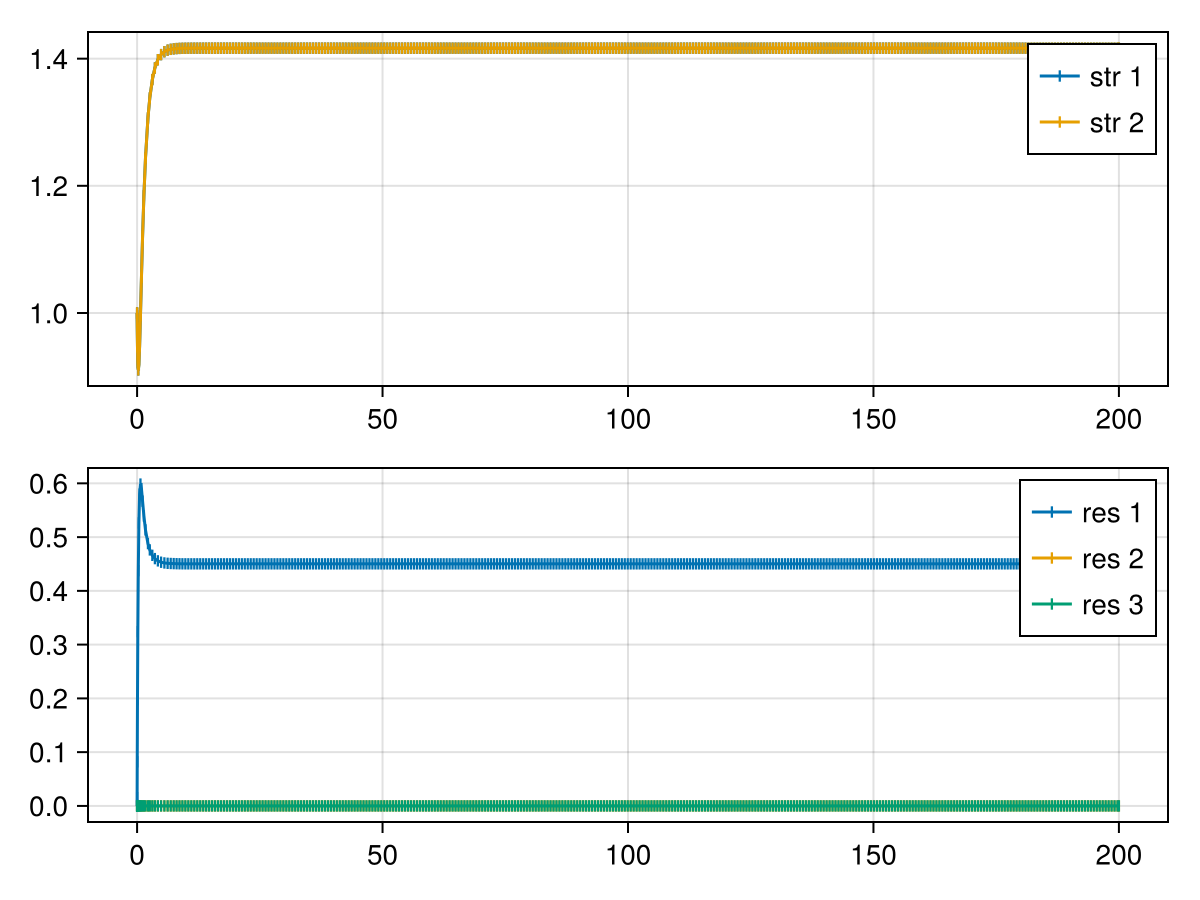

5-element Vector{Float64}:
 1.4166412226613654
 1.4166412226613654
 0.45005188180675576
 0.0
 0.0

In [27]:
params =  make_cosmo_mmicrm_params(0.9, 0., 3., 2., 10.)
u0 = make_u0_smart(params;
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p)

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]
# param_summary(p.p)

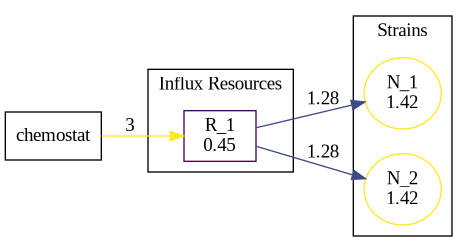

In [29]:
diagram_sfss_v3(params, s.u[end];
    cluster=true
)

# Basic Cosmo

## Basic no space solve

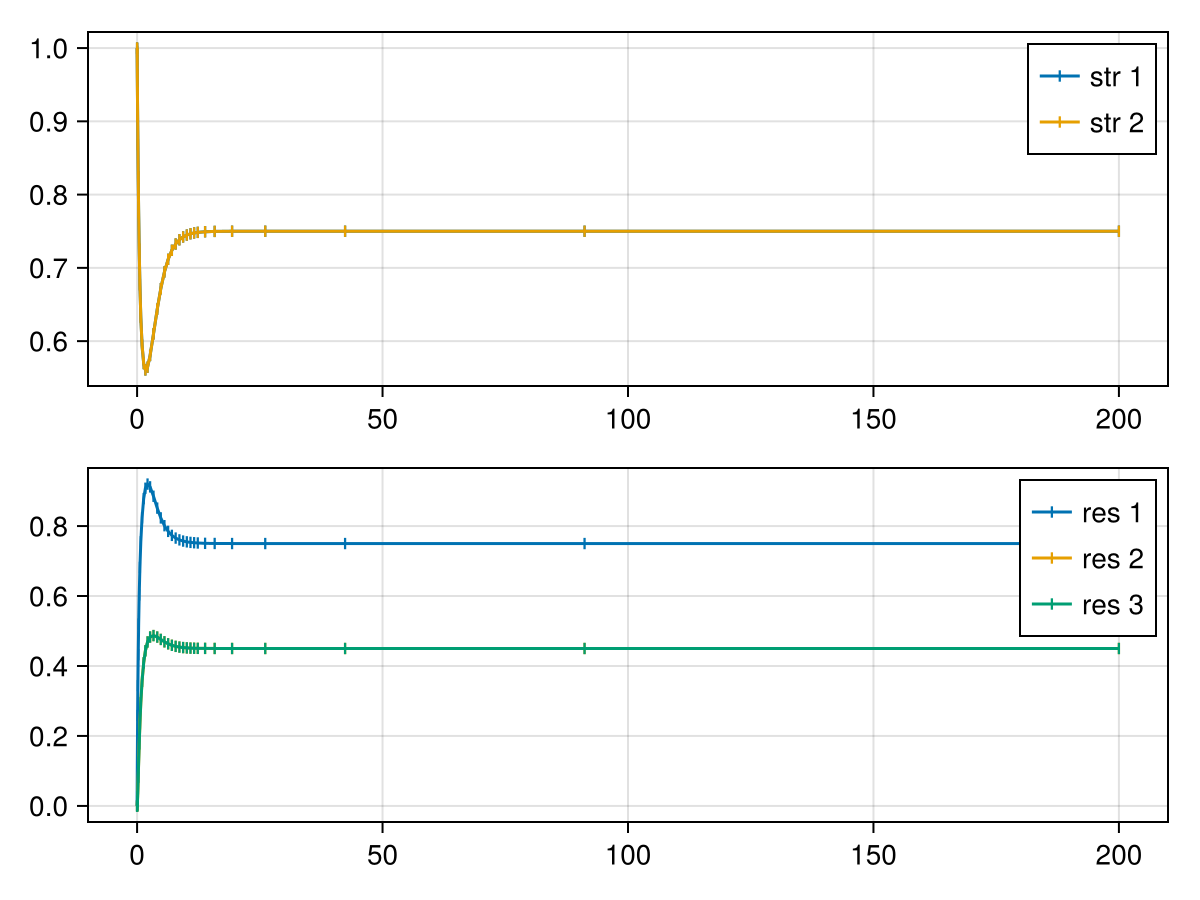

5-element Vector{Float64}:
 0.7499999950837934
 0.7499999950837934
 0.7500000042496404
 0.45000000174241855
 0.45000000174241855

In [11]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
params = make_sammicrmparams(2, 3;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
)

u0 = make_u0_smart(params;
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p)

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]
# param_summary(p.p)

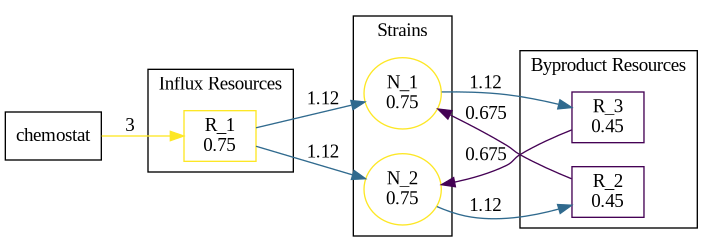

In [12]:
diagram_sfss_v3(params, s.u[end];
    cluster=true
)

#### Steady state solving

In [14]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/NPkhq/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.75, u2 => 0.75, u3 => 0.75, u4 => 0.45, u5 => 0.45]
 [u1 => 0.16666666666666666, u2 => 0.16666666666666666, u3 => 1.8, u4 => 0.45, u5 => 0.45]
 [u1 => 0.0, u2 => 0.0, u3 => 3.0, u4 => 0.0, u5 => 0.0]

In [15]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

## Spatial stuff

In [8]:
Ds = SA[0.01, 0.01, 1e2, 1., 1.];
usol = s.u[end]
nothing

In [9]:
da_get_diff_lengthscales_simple(params, Ds, usol)

(0.038729833537055926, Inf)

### Linear stability analysis

In [10]:
ks = LinRange(0., 10., 10000)
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, params, 0))

[2.613627797042001e-9, 2.613627797042001e-9, -2.2499420104793444e-9, -9.313096960283929e-10, -9.313096960283929e-10]

mrl = 0.23503411881277


┌ Info: Unstable, mrl is 0.235034
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/plotting.jl:92


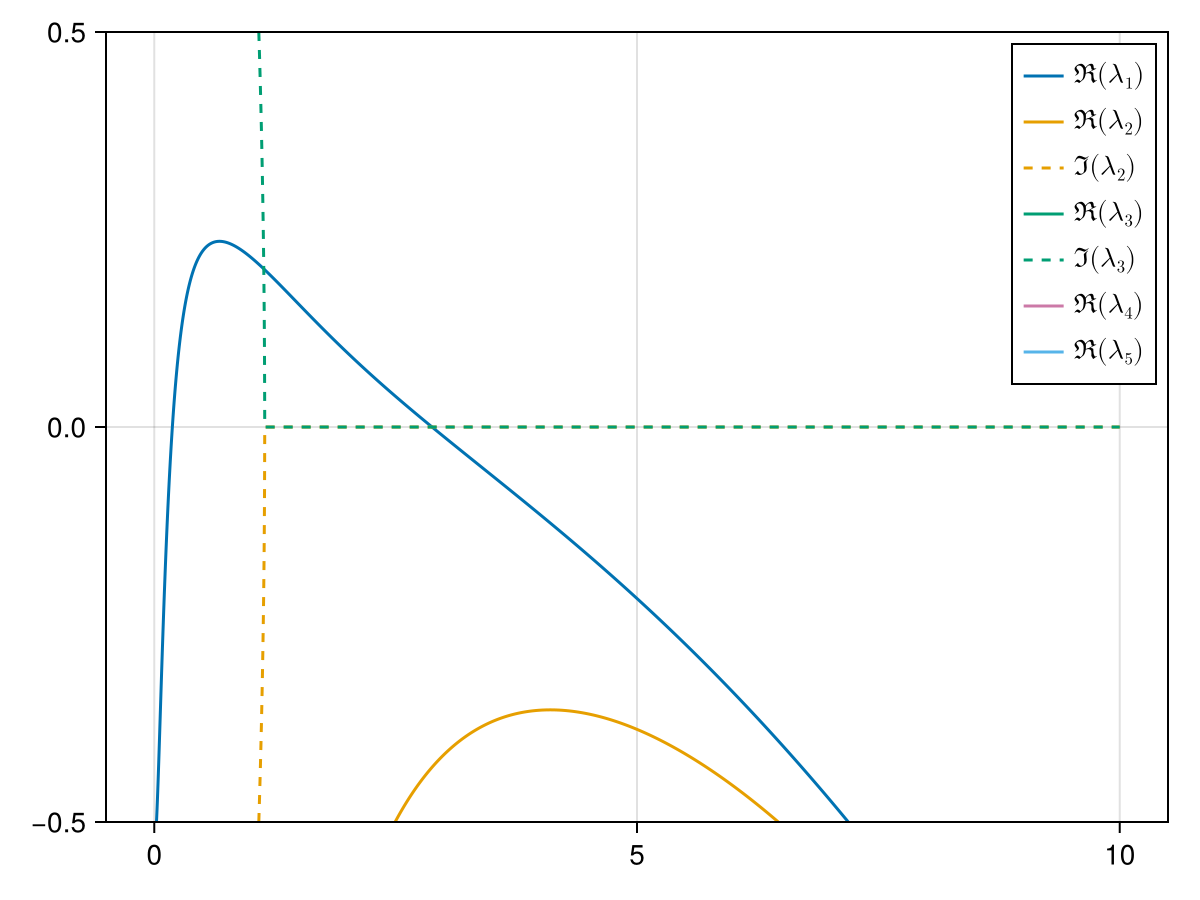

In [11]:
lambda_func = linstab_make_k_func(params, Ds, usol)
full_linstab_func = linstab_make_k_func(params, Ds, usol; returnobj=:full)

lambdas = lambda_func.(ks)
mrl = maximum(x->maximum(real,x), lambdas)
@show mrl

faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-0.5, 0.5))
# xlims!(faa.axis, (0., 2.))
faa

In [12]:
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
@show kmax
flmax = full_linstab_func(kmax)
flmax.vectors[:,1]

kmax = 0.6750675067506751


5-element Vector{ComplexF64}:
    0.6976388793421484 + 0.0im
    0.6976388793421476 + 0.0im
 -0.042020829253664724 + 0.0im
   0.11143212725533436 + 0.0im
   0.11143212725533427 + 0.0im

### Spatial stuff - 1D!

In [13]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform_prop(get_Ns(p.p)..., su0, 0.01, 0.01)

space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
sp = make_smmicrm_problem(sparams, psu0, 10000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 4000), 1, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [14]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 13.582695 seconds (30.24 M allocations: 2.885 GiB, 41.21% gc time, 76.58% compilation time)
Success
nf is 830
solution has 140 saved states
max resid is 0.000225813


┌ Warning: reaching negative values, minimum is -1.1936e-08
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


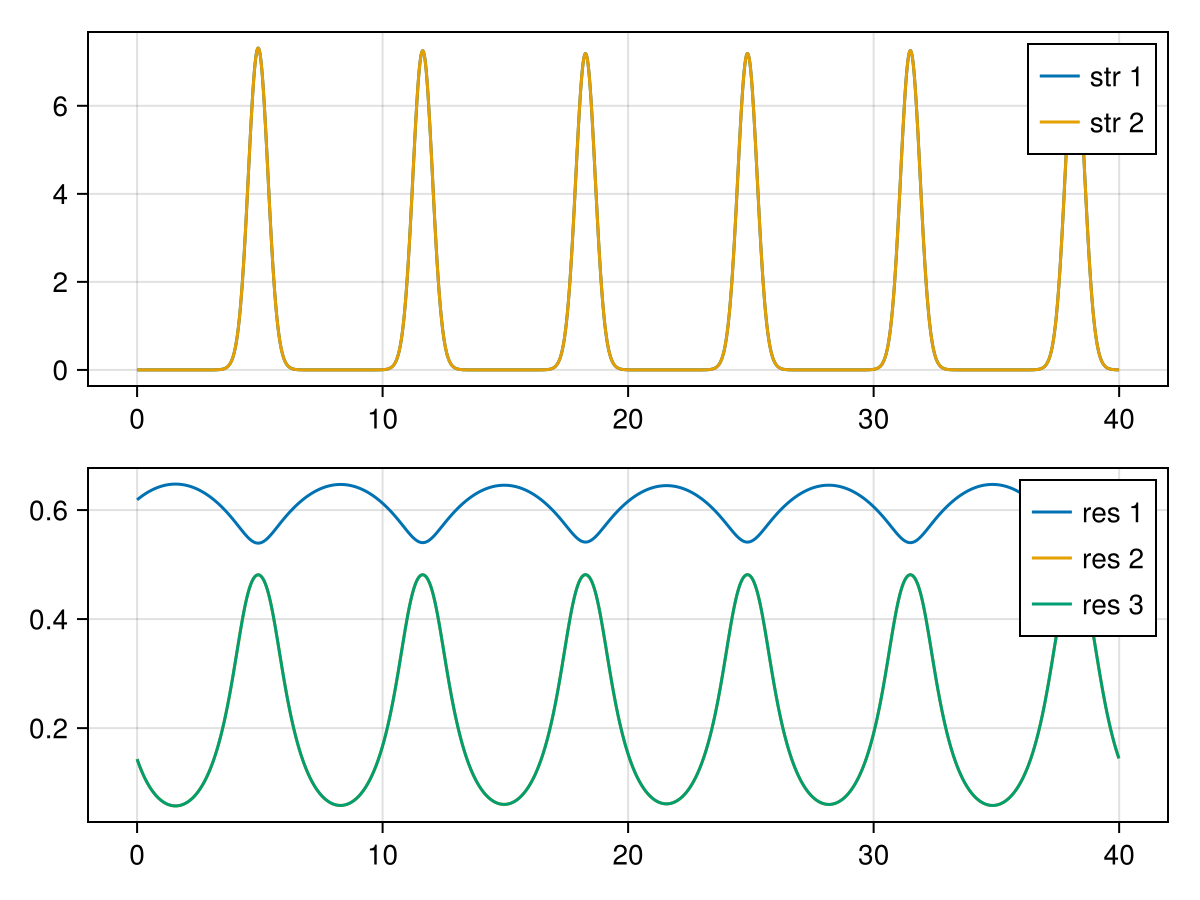

In [15]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
# display(GLMakie.Screen(), faa.figure)
faa

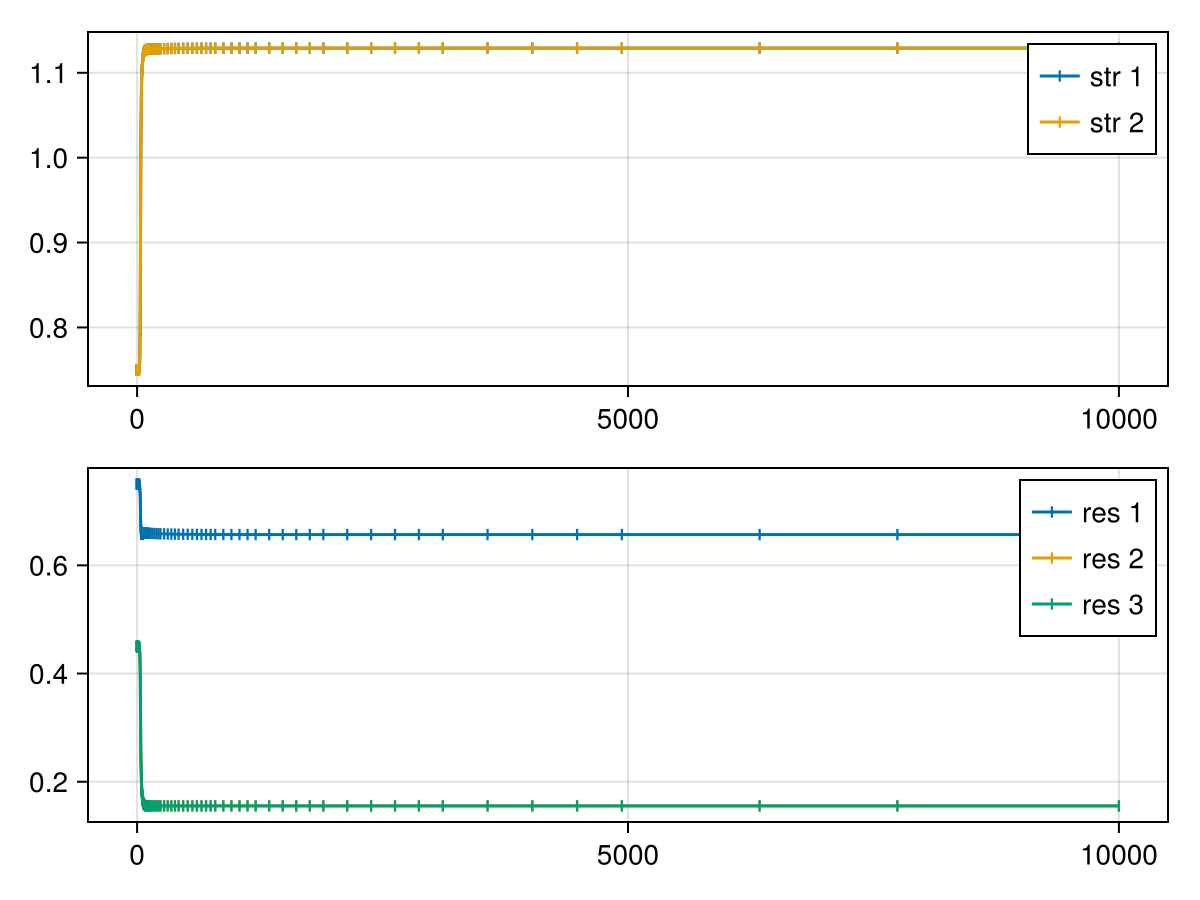

In [58]:
f = plot_smmicrm_sol_avgs(sps)
# display(GLMakie.Screen(), f)
f

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

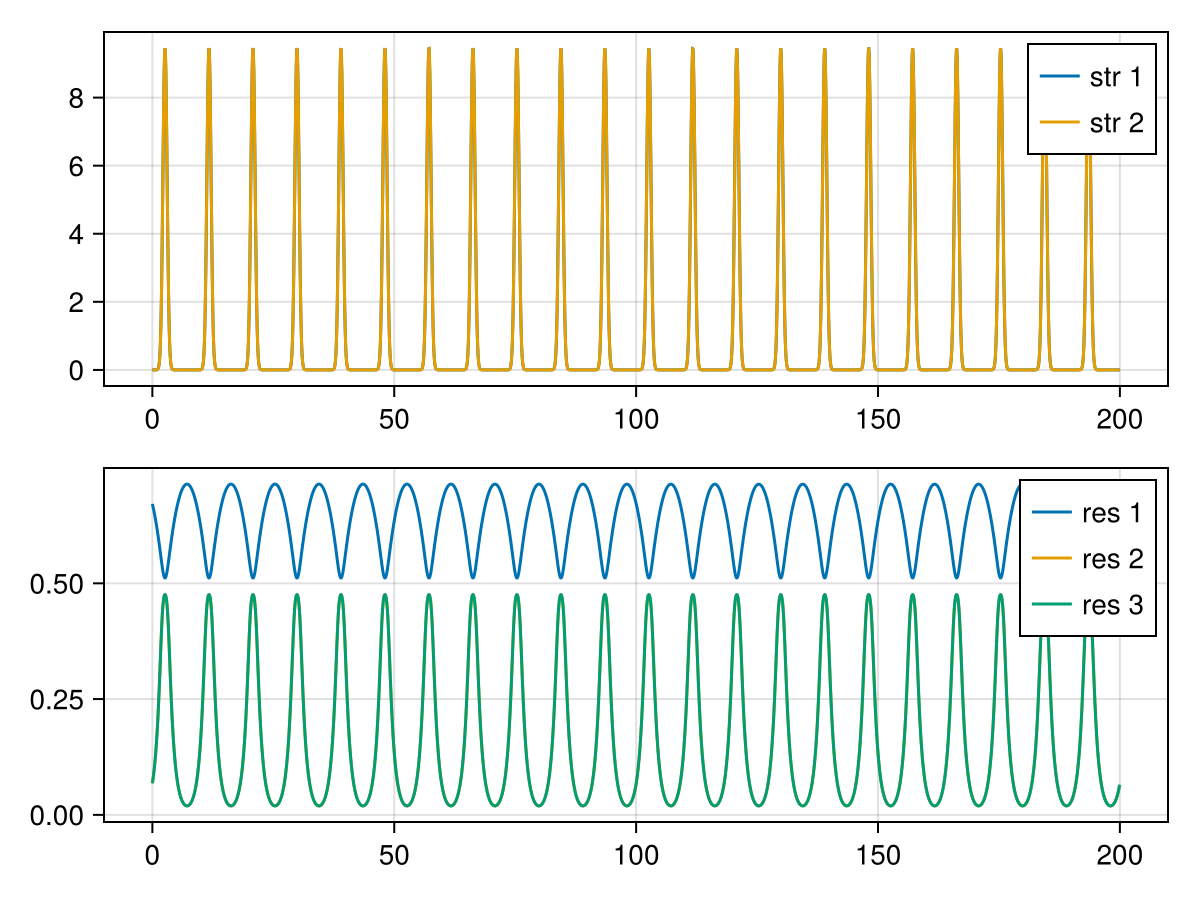

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

### Spatial stuff - 2D!

In [38]:
ssize = (70, 70)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform_prop(get_Ns(p.p)..., su0, 0.01, 0.01)

space = make_cartesianspace_smart(length(ssize); dx=0.3, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
sp = make_smmicrm_problem(sparams, psu0, 100000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 70, 70), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.3, 0.3]))

#### Direct solver

In [39]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 40.920091 seconds (707.03 k allocations: 9.403 GiB, 0.31% gc time)
Success
nf is 2238
solution has 248 saved states
max resid is 2.24162e-05


┌ Warning: reaching negative values, minimum is -1.67755e-09
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


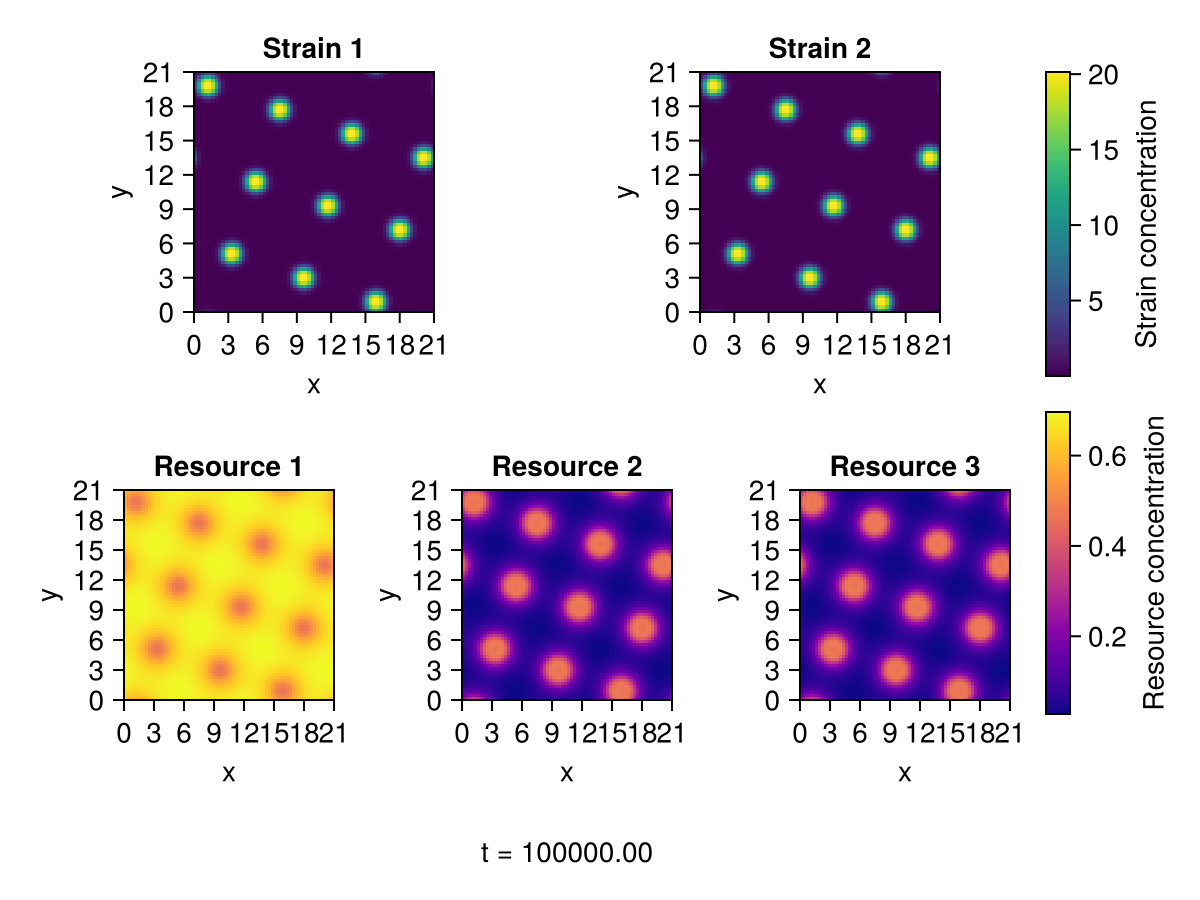

In [47]:
plot_2dsmmicrm_sol_snap_heatmap(sps, -1)
# display(GLMakie.Screen(), plot_2dsmmicrm_sol_interactive_heatmap(sps))

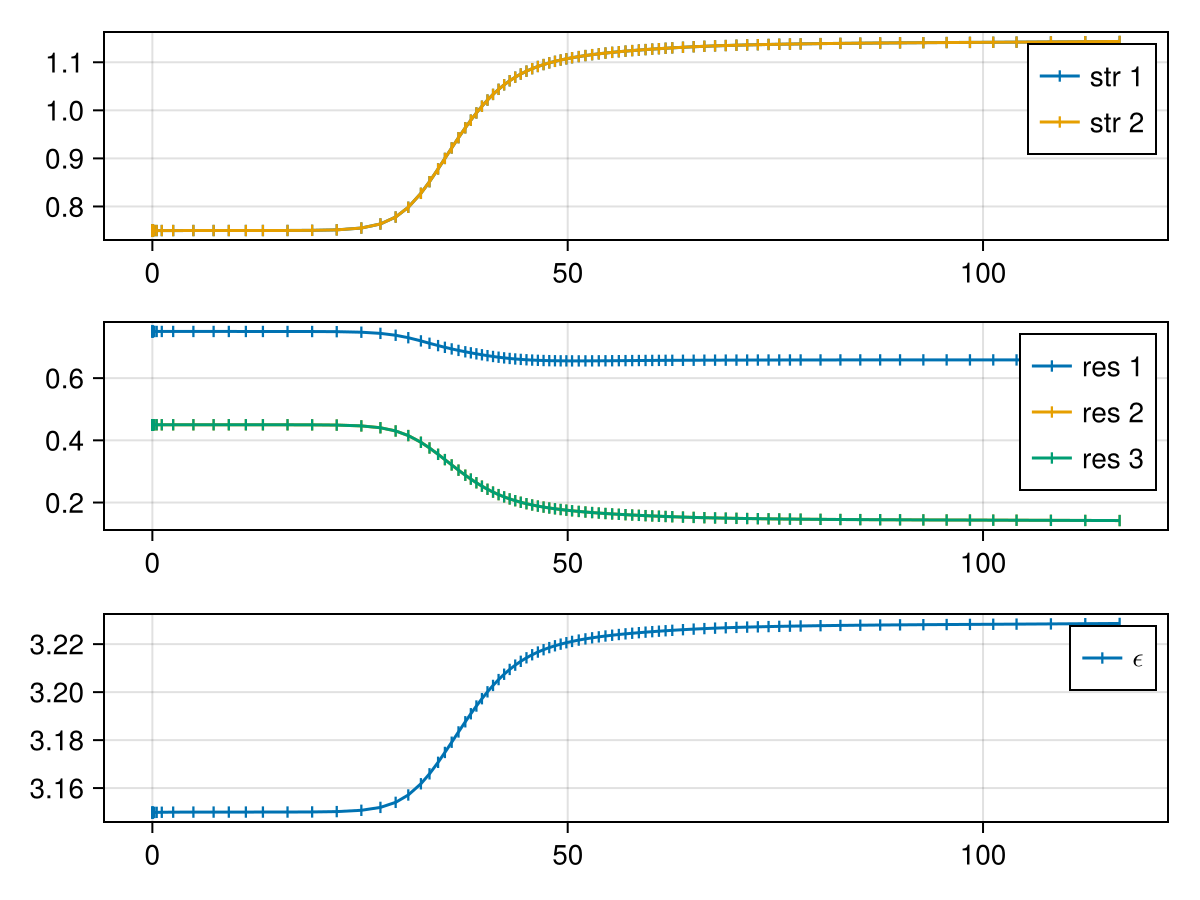

In [63]:
plot_smmicrm_sol_avgs(sps, 1:100; plote=true)

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()